## Evaluation Plots

In [74]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

In [75]:
import os
import h5py
import math
import json
import pickle
import corner
import scipy
import itertools
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import sklearn.metrics as metrics
import matplotlib.lines as mlines

import matplotlib as mpl
from functools import partial
from matplotlib.ticker import AutoMinorLocator
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.colors as mcolors

In [76]:
import sys
sys.path.insert(0, "../")
from evaluator import *

In [77]:
# Access results file for D4 testing
# parent_dir = "/local/scratch/igr/nnarenraju/testing_month_D4_seeded/"
parent_dir = "/home/nnarenraju/Research/ORChiD/test_data_d4/"
foreground = os.path.join(parent_dir, 'foreground.hdf')
background = os.path.join(parent_dir, 'background.hdf')
foutput = os.path.join(parent_dir, 'testing_foutput_BEST_June.hdf')
boutput = os.path.join(parent_dir, 'testing_boutput_BEST_June.hdf')
injections = os.path.join(parent_dir, 'injections.hdf')

In [78]:
far_scaling_factor = 2592000.0 # 30 days in seconds

### Preparation steps

In [79]:
# Find indices contained in foreground
print("Finding injections contained in data")
padding_start, padding_end = 30, 30
dur, idxs = find_injection_times([foreground],
                                 injections,
                                 padding_start=padding_start,
                                 padding_end=padding_end)
if np.sum(idxs) == 0:
    msg = 'The foreground data contains no injections! '
    msg += 'Probably a too small section of data was generated. '
    msg += 'Please make sure to generate at least {} seconds of data. '
    msg += 'Otherwise a sensitive distance cannot be calculated.'
    msg = msg.format(padding_start + padding_end + 24)
    raise RuntimeError(msg)

Finding injections contained in data


In [80]:
# Get injections optimal SNRs
_parent_dir = "/local/scratch/igr/nnarenraju/testing_month_D4_seeded/"
snrs_path = os.path.join(_parent_dir, "snr.hdf")
if os.path.exists(snrs_path):
    with h5py.File(snrs_path, 'r') as fp:
        snrs = fp['snr'][()]

snrs = np.array(snrs)
snrs = snrs[idxs]

In [81]:
# This checks out
print('Duration calculated by find_injection_times = {}'.format(dur))

Duration calculated by find_injection_times = 2592000.0


### Read Results

In [82]:
dataset = 4

team_1 = {'name': 'Sage'}
team_2 = {'name': 'PyCBC'}

In [83]:
injparams = {}
with h5py.File(injections, 'r') as fp:
    params = list(fp.keys())
    for param in params:
        data = fp[param][()]
        injparams[param] = data[idxs]
        
    use_chirp_distance = 'chirp_distance' in params

other_results = "/home/nnarenraju/Research/ORChiD/results"
other_teams = os.listdir(other_results)

print('Dataset {} comparing {} against {}'.format(dataset, team_1['name'], team_2['name']))
team_1['fgpath'] = foutput
team_1['bgpath'] = boutput
    
if team_2['name'] == 'PyCBC':
    team_2['fgpath'] = os.path.join(other_results, "{}/ds{}/fg.hdf".format(team_2['name'], dataset))
    team_2['bgpath'] = os.path.join(other_results, "{}/ds{}/bg.hdf".format(team_2['name'], dataset))
if team_2['name'] == 'aresgw':
    team_2['fgpath'] = "/home/nnarenraju/Research/ORChiD/gw-detection-deep-learning/results_best/fg.hdf"
    team_2['bgpath'] = "/home/nnarenraju/Research/ORChiD/gw-detection-deep-learning/results_best/bg.hdf"


for nteam in [1, 2]:
    team = locals()["team_{}".format(nteam)]
    print('\nTeam {}'.format(team))
    # Read foreground events
    print(f'Reading foreground events from {team["fgpath"]}')
    fg_events = []
    with h5py.File(team['fgpath'], 'r') as fp:
        fg_events.append(np.vstack([fp['time'], fp['stat'], np.array(fp['var'])]))
    team['fgevents'] = np.concatenate(fg_events, axis=-1)
    
    # Read background events
    print(f'Reading background events from {team["bgpath"]}')
    bg_events = []
    with h5py.File(team['bgpath'], 'r') as fp:
        bg_events.append(np.vstack([fp['time'], fp['stat'], np.array(fp['var'])]))
    team['bgevents'] = np.concatenate(bg_events, axis=-1)

Dataset 4 comparing Sage against PyCBC

Team {'name': 'Sage', 'fgpath': '/home/nnarenraju/Research/ORChiD/test_data_d4/testing_foutput_BEST_June.hdf', 'bgpath': '/home/nnarenraju/Research/ORChiD/test_data_d4/testing_boutput_BEST_June.hdf'}
Reading foreground events from /home/nnarenraju/Research/ORChiD/test_data_d4/testing_foutput_BEST_June.hdf
Reading background events from /home/nnarenraju/Research/ORChiD/test_data_d4/testing_boutput_BEST_June.hdf

Team {'name': 'PyCBC', 'fgpath': '/home/nnarenraju/Research/ORChiD/results/PyCBC/ds4/fg.hdf', 'bgpath': '/home/nnarenraju/Research/ORChiD/results/PyCBC/ds4/bg.hdf'}
Reading foreground events from /home/nnarenraju/Research/ORChiD/results/PyCBC/ds4/fg.hdf
Reading background events from /home/nnarenraju/Research/ORChiD/results/PyCBC/ds4/bg.hdf


### Evaluating Results

In [84]:
""" Calculate the false-alarm rate and sensitivity of a search algorithm. """

# Get data from fg and bg events file
print('Team 1: {}'.format(team_1['name']))
print('Team 2: {}'.format(team_2['name']))

Team 1: Sage
Team 2: PyCBC


In [85]:
# Add SNRs into the injparams (this will automagically include it within most plots)
chirp_distance = use_chirp_distance
injparams['snr'] = snrs
output_dir = "./evaluation_plots/"
# Return data tmp var
ret = {}

## COMMON ##
# Get injection params
injtimes = injparams['tc']
dist = injparams['distance']

# Get chirp mass from the source masses
if chirp_distance:
    massc = mchirp(injparams['mass1'], injparams['mass2'])
# Set duration if nothing is passed
duration = dur

In [86]:
def network_output(found_injections, noise_stats, output_dir, team_name, lower_threshold=0.0):
    # Plotting the noise and signals stats for found samples
    plt.figure(figsize=(12.0, 12.0))
    foo = found_injections[1][found_injections[1] > lower_threshold]
    plt.hist(foo, label='found_injections', bins=100, alpha=0.8)
    noise_stats = noise_stats[noise_stats > lower_threshold]
    plt.hist(noise_stats, label='noise', bins=100, alpha=0.8)
    plt.yscale('log')
    plt.grid(True, which='both')
    plt.legend()
    plt.savefig(os.path.join(output_dir, 'network_output_{}.png'.format(team_name)))
    plt.close()

In [87]:
for team in [team_1, team_2]:
    
    print('\nTeam {}'.format(team['name']))
    print('Sorting foreground event times')
    sidxs = team["fgevents"][0].argsort()
    fgevents = team["fgevents"].T[sidxs].T
    
    logging.info('Finding injection times closest to event times')
    idxs = find_closest_index(injtimes, fgevents[0])
    diff = np.abs(injtimes[idxs] - fgevents[0])
    
    # If the difference between the injection time and trigger is within tc variance
    # The trigger is identified as an event (there may be duplicate triggers)
    logging.info('Finding true- and false-positives')
    tpbidxs = diff <= fgevents[2]
    tpidxs = np.arange(len(fgevents[0]))[tpbidxs]
    fpbidxs = diff > fgevents[2]
    fpidxs = np.arange(len(fgevents[0]))[fpbidxs]
    
    tpevents = fgevents.T[tpidxs].T
    fpevents = fgevents.T[fpidxs].T
    
    ## Update the returns dictionary
    if team['name'] == "Sage":
        ret['fg-events'] = fgevents
        ret['found-indices'] = np.arange(len(injtimes))[idxs]
        ret['missed-indices'] = np.setdiff1d(np.arange(len(injtimes)), ret['found-indices'])
        ret['true-positive-event-indices'] = tpidxs
        ret['false-positive-event-indices'] = fpidxs
        ret['sorting-indices'] = sidxs
        ret['true-positive-diffs'] = diff[tpidxs]
        ret['false-positive-diffs'] = diff[fpidxs]
        ret['true-positives'] = tpevents
        ret['false-positives'] = fpevents
    
    # Calculate foreground FAR
    logging.info('Calculating foreground FAR')
    noise_stats_fg = fpevents[1].copy()
    noise_stats_fg.sort()
    fgfar = len(noise_stats_fg) - np.arange(len(noise_stats_fg)) - 1
    fgfar = fgfar / duration
    if team['name'] == "Sage":
        ret['fg-far'] = fgfar
    
    # Calculate background FAR
    logging.info('Calculating background FAR')
    noise_stats = team["bgevents"][1].copy()
    noise_stats.sort()
    far = len(noise_stats) - np.arange(len(noise_stats)) - 1
    far = far / duration
    if team['name'] == "Sage":
        ret['far'] = far
    
    # Find best true-positive for each injection
    found_injections = []
    tmpsidxs = idxs.argsort()
    sorted_idxs = idxs[tmpsidxs]
    iidxs = np.full(len(idxs), False)
    for i in tqdm(range(len(injtimes)), ascii=True, desc='Determining found injections'):
        L = np.searchsorted(sorted_idxs, i, side='left')
        if L >= len(idxs) or sorted_idxs[L] != i:
            continue
        R = np.searchsorted(sorted_idxs, i, side='right')
        # All indices that point to the same injection
        iidxs[tmpsidxs[L:R]] = True
        # Indices of the true-positives that belong to the same injection
        eidxs = np.logical_and(iidxs[tmpsidxs[L:R]],
                                tpbidxs[tmpsidxs[L:R]])
        if eidxs.any():
            found_injections.append([i, np.max(fgevents[1][tmpsidxs[L:R]][eidxs])])
        iidxs[tmpsidxs[L:R]] = False

    # Number of injections found within given testing data
    found_injections = np.array(found_injections).T
    print('Number of found injections = {}'.format(len(found_injections[0])))
    
    # Calculate sensitivity
    # CARE! THIS APPLIES ONLY WHEN THE DISTRIBUTION IS CHOSEN CORRECTLY
    logging.info('Calculating sensitivity')
    sidxs = found_injections[1].argsort() # Sort found injections
    found_injections = found_injections.T[sidxs].T
    
    if chirp_distance:
        found_mchirp_total = massc[found_injections[0].astype(int)]
        mchirp_max = massc.max()
        
    max_distance = dist.max()
    # print('Maximum distance given by injections = {}'.format(max_distance))
    vtot = (4. / 3.) * np.pi * max_distance**3.
    Ninj = len(dist)
    print('Total number of injections = {}'.format(Ninj))
    
    # Params to calculate the sensitive volume
    if chirp_distance:
        mc_norm = mchirp_max ** (5. / 2.) * len(massc)
    else:
        mc_norm = Ninj
        
    prefactor = vtot / mc_norm
    nfound = len(found_injections[1]) - np.searchsorted(found_injections[1],
                                                        noise_stats,
                                                        side='right')
    
    
    if chirp_distance:
        # Get found chirp-mass indices for given threshold
        fidxs = np.searchsorted(found_injections[1], noise_stats, side='right')
        # Plotting the network output
        network_output(found_injections, noise_stats, output_dir, team['name'], lower_threshold=-999)
        
        found_mchirp_total = np.flip(found_mchirp_total)
        
        # Calculate sum(found_mchirp ** (5/2))
        # with found_mchirp = found_mchirp_total[i:]
        # and i looped over fidxs
        # Code below is a vectorized form of that
        cumsum = np.flip(np.cumsum(found_mchirp_total ** (5./2.)))
        cumsum = np.concatenate([cumsum, np.zeros(1)])
        mc_sum = cumsum[fidxs]
        Ninj = np.sum((mchirp_max / massc) ** (5. / 2.))
        
        cumsumsq = np.flip(np.cumsum(found_mchirp_total ** 5))
        cumsumsq = np.concatenate([cumsumsq, np.zeros(1)])
        sample_variance_prefactor = cumsumsq[fidxs]
        sample_variance = sample_variance_prefactor / Ninj\
                            - (mc_sum / Ninj) ** 2  # noqa: E127
    else:
        mc_sum = nfound
        sample_variance = nfound / Ninj - (nfound / Ninj) ** 2
        
    vol = prefactor * mc_sum
    vol_err = prefactor * (Ninj * sample_variance) ** 0.5
    rad = (3 * vol / (4 * np.pi))**(1. / 3.)
    print('Radius or sensitive distance as calculated from the volume obtained ({})'.format(team['name']))
    print('min rad = {}, max rad = {}'.format(min(rad), max(rad)))
    
    if team['name'] == "Sage":
        ret['sensitive-volume'] = vol
        ret['sensitive-distance'] = rad
        ret['sensitive-volume-error'] = vol_err
        ret['sensitive-fraction'] = nfound / Ninj
    
    if team['name'] == "PyCBC" or team['name'] == "aresgw":
        ret['sensitive-distance-pycbc'] = rad
        ret['far-pycbc'] = far
    
    # Update plotting params for each group
    team['found_idx'] = found_injections[0].astype(int)
    team['found_stats'] = found_injections[1]
    # Add all found injparams to to plotting dict
    team['params'] = list(injparams.keys())
    team.update(injparams)
    # The values given are indices and have to be 1 less than the number of FA per month req.
    team['far_thresholds'] = noise_stats[::-1][[0, 3, 29, 99, 999]]
    team['noise_stats'] = noise_stats[::-1]
    team['sens_dist'] = rad
    team['sens_frac'] = nfound / Ninj


Team Sage
Sorting foreground event times


Determining found injections: 100%|##########| 95719/95719 [00:02<00:00, 42183.05it/s]


Number of found injections = 33603
Total number of injections = 95719
Radius or sensitive distance as calculated from the volume obtained (Sage)
min rad = 1580.9784480084643, max rad = 3107.893399526575

Team PyCBC
Sorting foreground event times


Determining found injections: 100%|##########| 95719/95719 [00:01<00:00, 61368.76it/s]


Number of found injections = 12450
Total number of injections = 95719
Radius or sensitive distance as calculated from the volume obtained (PyCBC)
min rad = 1538.767654239908, max rad = 2233.5425765258606


### Found/Missed Corner Plot

In [88]:
# Colour table
# orange/purple - "#EB6123", "#512888"
# blue/red - "#2F67B1", "#BF2C23"
# pale blue - "#3A93C3", dark blue - "#1065AB"
# pale red - "#D75F4C", dark red - "#B31529"
# pale green - "#5CAE63", dark green - "#1B7939"
# Super light blue/green - "#D1E5F0", "#D9F1D5"
# yellow/blue - "#FDB338", "#025196"
# dark purple - "#742881"

# Ross color scale - ["#000000","#6db6ff","#009292","#ff6db6","#924900","#490092","#006ddb","#b66dff","#004949","#b6dbff","#920000","#ffb6db","#db6d00","#24ff24","#ffff6d"]
# Plasma perceptually uniform - cmap = plt.cm.plasma
# "#F57D15", "#65156E"

dark_purple = "#742881"
dark_green = "#1B7939"
dark_blue = "#1065AB"
dark_red = "#BF2C23"
taupe = "#B9A281"
sage_green = "#0A5C36"
terracotta = "#CB6843"
light_terracotta = "#DA957B"
raspberry = "#E30B5C"
brown = "#A68A64"
dark_brown = "#855e46"
yellow = "#FDB338"
blue = "#025196"

# Nice plasma
# colors_histogram = ["#D44842", "#65156E"]
# colors_scatter = ["#D44842", "#65156E"]

# cmap colors
choose_cmap = mpl.colormaps['turbo']
hex_left = mpl.colors.rgb2hex(choose_cmap(0.05), keep_alpha=True)
hex_right = mpl.colors.rgb2hex(choose_cmap(0.95), keep_alpha=True)

colors_histogram = [hex_left, hex_right]

# blue --> yellow
# colors_histogram = ["#DAA520", "#00346e"] # yellow/blue
# colors_histogram = ["#936b09", "#00346e"]
# colors_scatter = ["#DAA520", "#00346e"]

In [89]:
coord_to_name = {}
coord_to_name[0] = 'mchirp'
coord_to_name[1] = 'q'
coord_to_name[2] = 'distance'
coord_to_name[3] = 'snr'

In [90]:
name_to_label = {}
name_to_label['distance'] = r'$D$'
name_to_label['snr'] = r'$\rho$'
name_to_label['q'] = r'$q$'
name_to_label['mchirp'] = r'$\mathcal{M}_c$'

In [91]:
thresh_names = ['1-per-month', '1-per-week', '1-per-day', '100-per-month', '1000-per-month']
# How many signals are present above given threshold?
for n, thresh in enumerate(team_1["far_thresholds"]):
    team_1[thresh_names[n]] = team_1['found_idx'][team_1["found_stats"] > thresh]
for n, thresh in enumerate(team_2["far_thresholds"]):
    team_2[thresh_names[n]] = team_2['found_idx'][team_2["found_stats"] > thresh]

In [92]:
thresh_name = '1-per-month'

In [93]:
plotting_params = ['mchirp', 'q', 'distance', 'snr']
data_pycbc = {}
data_sage = {}
for param in plotting_params:
    data_sage[param] = team_1[param][team_1[thresh_name]]
    data_pycbc[param] = team_2[param][team_2[thresh_name]]

In [94]:
# hue_neg, hue_pos = 260, 15
hue_neg, hue_pos = 260, 15
cmap_diverging_dark = sns.diverging_palette(hue_neg, hue_pos, sep=1, center="dark", as_cmap=True)
print(cmap_diverging_dark) # this is a matplotlib object

In [95]:
cmap_segmented = cmap_diverging_dark  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap_segmented(i) for i in range(cmap_segmented.N)]

# create the new map
cmap_segmented = mpl.colors.LinearSegmentedColormap.from_list(
            'Custom cmap', cmaplist, cmap_segmented.N)

# define the bins and normalize
# Should have -1 and 1 but not 0
# pycbc - bounds = np.linspace(-11, 11, 12)
bounds = np.arange(-22, 24, 2)
print(bounds)
norm = mpl.colors.BoundaryNorm(bounds, cmap_segmented.N)

[-22 -20 -18 -16 -14 -12 -10  -8  -6  -4  -2   0   2   4   6   8  10  12
  14  16  18  20  22]


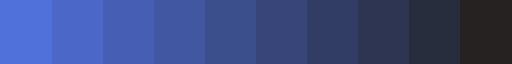

In [96]:
ListedColormap(cmap_diverging_dark(np.linspace(0.0, 0.50, 10)))

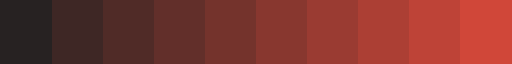

In [97]:
ListedColormap(cmap_diverging_dark(np.linspace(0.50, 1.0, 10)))

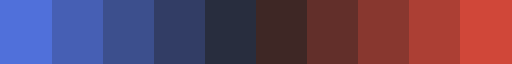

In [98]:
ListedColormap(cmap_diverging_dark(np.linspace(0.0, 1.0, 10)))

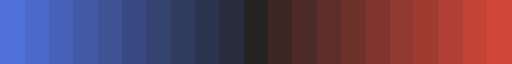

In [99]:
ListedColormap(cmap_diverging_dark(np.linspace(0.0, 1.0, 21)))

[0.         0.06666667 0.13333333 0.2        0.26666667 0.33333333
 0.4        0.5        0.6        0.64444444 0.68888889 0.73333333
 0.77777778 0.82222222 0.86666667 0.91111111 0.95555556 1.        ]


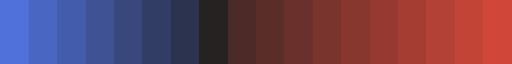

In [100]:
# Create custom colormap based on limits provided
# We need an odd number of colors to include zero difference
limits = (-7, 10)
lower = np.linspace(0.0, 0.40, abs(limits[0]))
upper = np.linspace(0.60, 1.0, abs(limits[1]))
full = np.concatenate((lower, [0.5], upper))
print(full)

required = full[:]
ListedColormap(cmap_diverging_dark(required))

In [101]:
custom_diverging_cmap = ListedColormap(cmap_diverging_dark(required))

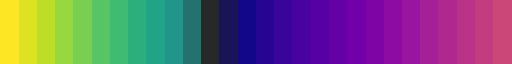

In [102]:
colors1 = plt.cm.viridis_r(np.linspace(0.0, 0.5, abs(limits[0])))
colors2 = plt.cm.plasma(np.linspace(0.0, 0.5, abs(limits[1])))
black = cmap_diverging_dark([0.5])

# combine them and build a new colormap
colors = np.vstack((colors1, black, colors2))
custom = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)
ListedColormap(custom(np.linspace(0, 1, 28)))

In [103]:
custom_perceptually_uniform = ListedColormap(custom(np.linspace(0, 1, 28)))

In [104]:
all_diffs = []

In [105]:
def reduce_function(z):
    z = np.array(z)
    num_pycbc = len(z[z == 0])
    num_sage = len(z[z == 1])
    all_diffs.append(num_sage-num_pycbc)
    return num_sage-num_pycbc

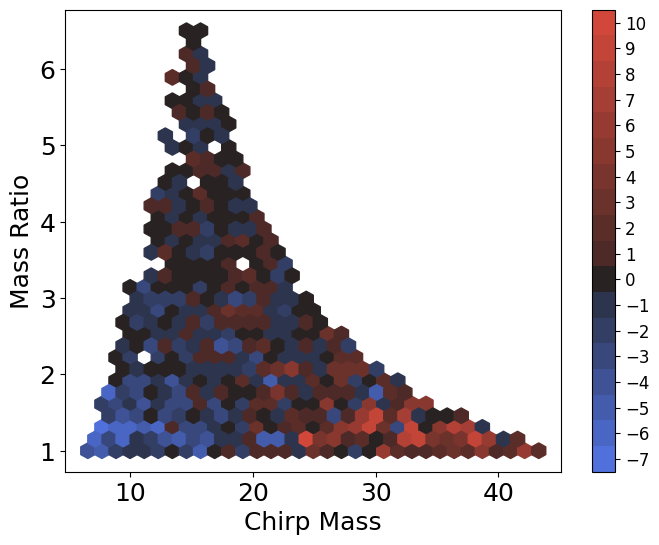

In [106]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
x_data = np.hstack((data_pycbc['mchirp'], data_sage['mchirp']))
y_data = np.hstack((data_pycbc['q'], data_sage['q']))
Z = np.hstack((np.full(len(data_pycbc['mchirp']), 0), np.full(len(data_sage['mchirp']), 1)))
# rf = partial(reduce_function, arg=arg)
# hexb = plt.hexbin(x_data, y_data, C=Z, reduce_C_function=reduce_function, gridsize=32, cmap=cmap_segmented, vmin=-5, vmax=22)
# hexb = plt.hexbin(x_data, y_data, C=Z, reduce_C_function=reduce_function, gridsize=32, cmap=cmap_segmented, norm=norm)
hexb = plt.hexbin(x_data, y_data, C=Z, reduce_C_function=reduce_function, gridsize=32, cmap=custom_diverging_cmap, norm=mpl.colors.Normalize(vmin=-7.5,vmax=10.5))
cbar = plt.colorbar(hexb, ticks=np.arange(-7.0, 11.0, 1))
cbar.ax.tick_params(labelsize=12)
plt.xlabel('Chirp Mass')
plt.ylabel('Mass Ratio')

positions = hexb.get_offsets()
values = hexb.get_array()

In [107]:
max(all_diffs), min(all_diffs)

(10, -7)

In [108]:
# Should include a zero
# pycbc - np.linspace(-12.0, 12.0, 13)
np.arange(-5.0, 24.0, 2.0)

array([-5., -3., -1.,  1.,  3.,  5.,  7.,  9., 11., 13., 15., 17., 19.,
       21., 23.])

In [109]:
print(min(all_diffs), max(all_diffs))

-7 10


/tmp/ipykernel_2173078/3556888802.py:15: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  paxis = plt.subplot(gs[int(4*coord[0]+coord[1])])
/tmp/ipykernel_2173078/3556888802.py:38: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(gs[int(4*coord[0]+coord[1])])
/tmp/ipykernel_2173078/3556888802.py:43: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ppaxis = plt.subplot(gs[int(4*coord[0]+coord[1])])


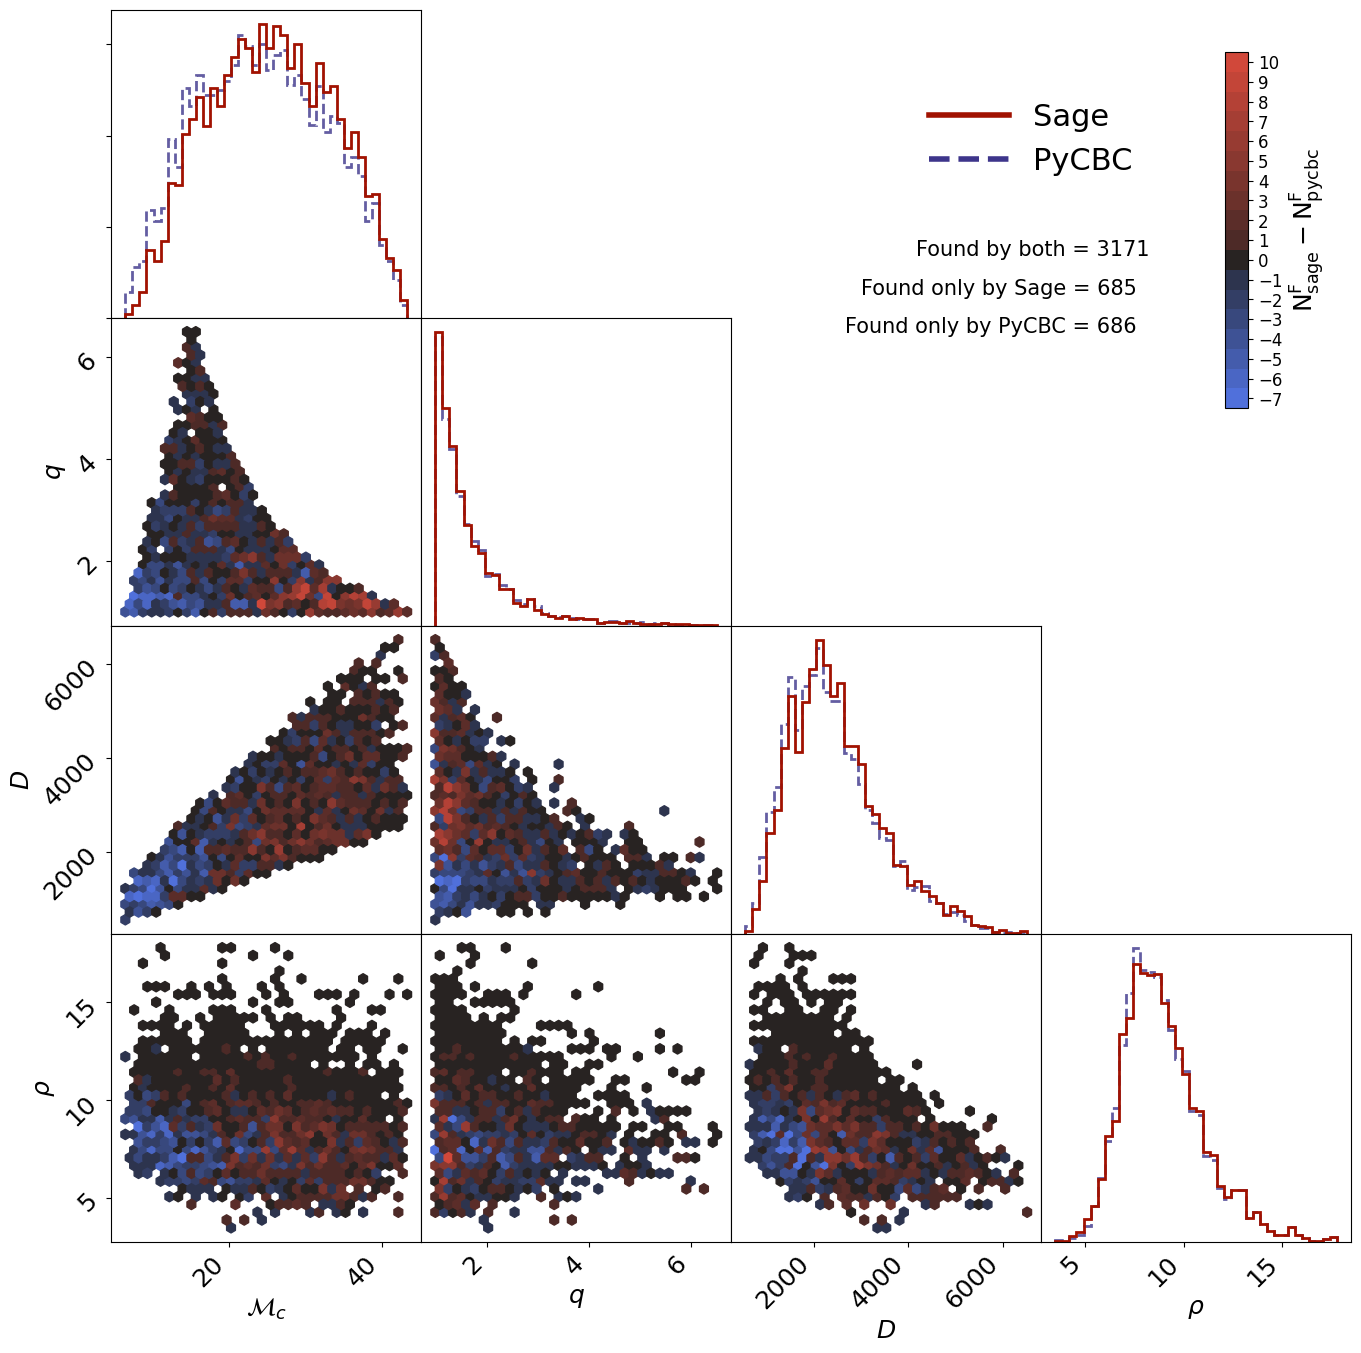

In [110]:
# create figure and axes
num_rows = len(data_sage.keys())
num_cols = len(data_sage.keys())
fig, axes = plt.subplots(num_rows, num_cols, figsize=(4*num_rows, 4*num_cols), facecolor='white')
gs = gridspec.GridSpec(num_rows, num_cols, wspace=0, hspace=0)
tick_rotation = 45.0 # degrees
flag = True
    
coords = itertools.product(np.arange(num_rows), np.arange(num_cols))
names = itertools.product(list(data_sage.keys()), list(data_sage.keys()))
for name, coord in zip(names, coords):
    param_1, param_2 = name
    if coord[0] == coord[1]:
        assert param_1 == param_2
        paxis = plt.subplot(gs[int(4*coord[0]+coord[1])])
        ax = paxis
        # Sanity check with histogram
        bins = np.histogram(np.hstack((data_pycbc[param_1], data_sage[param_1])), bins=40)[1]
        ax.hist(data_pycbc[param_1], density=False, bins=bins, alpha=0.8, histtype='step', color=colors_histogram[0], linewidth=2.0, linestyle='dashed')
        ax.hist(data_sage[param_1], density=False, bins=bins, alpha=1.0, histtype='step', color=colors_histogram[1], linewidth=2.0, linestyle='solid')
        plt.setp(ax.get_xticklabels(), rotation=tick_rotation, horizontalalignment='right')
        plt.setp(ax.get_yticklabels(), rotation=tick_rotation, horizontalalignment='right')

        if coord[1] == 0:
            ax.set_xticklabels([])
            ax.set_yticklabels([])
        elif coord[0] == num_cols-1:
            paxis.set_xlabel(name_to_label[coord_to_name[coord[1]]])
            ax.set_yticklabels([])
            ax.set_yticks([])
        else:
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_xticks([])
            ax.set_yticks([])

    elif coord[1] > coord[0]:
        ax = plt.subplot(gs[int(4*coord[0]+coord[1])])
        ax.remove()
        continue

    else:
        ppaxis = plt.subplot(gs[int(4*coord[0]+coord[1])])
        # marker = '+' if n==0 else 'o'
        # s = 20 if n==0 else 25
        # kwargs = {'color':colors_scatter[n]} if n==0 else {'edgecolors':colors_scatter[n], 'facecolors':'none'}
        # ppaxis.scatter(p2_data, p1_data, s=s, alpha=0.8, marker=marker, **kwargs)

        ##  Replacing the scatter plot with hexbinned color plot
        x_data = np.hstack((data_pycbc[coord_to_name[coord[0]]], data_sage[coord_to_name[coord[0]]]))
        y_data = np.hstack((data_pycbc[coord_to_name[coord[1]]], data_sage[coord_to_name[coord[1]]]))
        Z = np.hstack((np.full(len(data_pycbc[coord_to_name[coord[0]]]), 0), np.full(len(data_sage[coord_to_name[coord[0]]]), 1)))
        hexb = plt.hexbin(y_data, x_data, C=Z, reduce_C_function=reduce_function, gridsize=32, cmap=custom_diverging_cmap, norm=mpl.colors.Normalize(vmin=-7.5,vmax=10.5))

        if flag:
            # left/right, up/down, width, height
            cax = ppaxis.inset_axes([150.0, 5.0, 3.0, 7.0], transform=ppaxis.transData)
            cbar = fig.colorbar(hexb, cax=cax, orientation='vertical', ticks=np.arange(-7.0, 11.0, 1.0))
            cbar.set_label(r'$\mathregular{N^F_{sage} - N^F_{pycbc}}$', rotation=90)
            cbar.ax.tick_params(labelsize=12)
            flag = False

        name = 'PyCBC' if n==0 else 'Sage'
        """
        corner.hist2d(p2_data, p1_data,
                    ax=ppaxis, color=colors_fill[n],
                    levels=[0.95, 0.68], bins=512, smooth=42.,
                    plot_datapoints=False, plot_contours=True, fill_contours=False,
                    plot_density=False, contour_kwargs=contour_dict[name])
        """
        # Rotate tick labels
        plt.setp(ppaxis.get_xticklabels(), rotation=tick_rotation, horizontalalignment='right')
        plt.setp(ppaxis.get_yticklabels(), rotation=tick_rotation, horizontalalignment='right')

        if coord[1] == 0:
            ppaxis.set_ylabel(name_to_label[param_1])
            if coord[0] != num_rows - 1:
                ppaxis.set_xticklabels([])
                ppaxis.set_xticks([])
        if coord[0] == num_cols-1:
            ppaxis.set_xlabel(name_to_label[param_2])
            if coord[1] != 0:
                ppaxis.set_yticklabels([])
                ppaxis.set_yticks([])
        if coord[1] !=0 and coord[0] != num_cols-1:
            ppaxis.set_xticklabels([])
            ppaxis.set_yticklabels([])
            ppaxis.set_xticks([])
            ppaxis.set_yticks([])

## save the plot
fig.subplots_adjust(wspace=0)
fig.subplots_adjust(hspace=0)
# Legend
sage_line = mlines.Line2D([], [], color=colors_histogram[1], label='Sage', linewidth=4.0)
pycbc_line = mlines.Line2D([], [], color=colors_histogram[0], label='PyCBC', linewidth=4.0, linestyle='dashed')
# left/right, up/down, width, height
plt.legend(handles=[sage_line, pycbc_line], bbox_to_anchor=(-0.45, 0.33, 1., 6.5), loc='center left', frameon=False, fontsize=22, handlelength=2.6)
# Found and missed numbers
sage_set = set(data_sage['mchirp'])
pycbc_set = set(data_pycbc['mchirp'])
found_by_both = len(set.intersection(sage_set, pycbc_set))
found_only_by_sage = len(sage_set - pycbc_set)
found_only_by_pycbc = len(pycbc_set - sage_set)
plt.text(0.35, 3.2, 'Found by both = {}'.format(str(found_by_both)), transform=ax.transAxes, horizontalalignment='right', fontsize=15)
plt.text(0.35, 3.2-0.125, 'Found only by Sage = {}'.format(str(found_only_by_sage)+'  '), transform=ax.transAxes, horizontalalignment='right', fontsize=15)
plt.text(0.35, 3.2-0.250, 'Found only by PyCBC = {}'.format(str(found_only_by_pycbc)+'  '), transform=ax.transAxes, horizontalalignment='right', fontsize=15)

plt.savefig("./evaluation_plots/compare_hexbinned.png", bbox_inches='tight', dpi=500)

### Making found/missed histograms at different FARs

In [111]:
save_dir = os.path.join(output_dir, "histogram")

# Plot 1 (Histogram of all injections with found injections of both pipelines)
os.makedirs(save_dir, exist_ok=False)
# params = team_1['params']
params = ['mass1', 'mass2', 'mchirp',
          'q', 'distance', 'chirp_distance',
          'coa_phase', 'inclination', 'polarization',
          'ra', 'dec', 'snr',
          'spin1x', 'spin1y', 'spin1z',
          'spin2x', 'spin2y', 'spin2z']

ncols = 3
nrows = len(params)//ncols + int(len(params)%ncols or False)

thresh_names = ['1-per-month', '1-per-week', '1-per-day', '100-per-month', '1000-per-month']
# How many signals are present above given threshold?
for n, thresh in enumerate(team_1["far_thresholds"]):
    team_1[thresh_names[n]] = team_1['found_idx'][team_1["found_stats"] > thresh]
for n, thresh in enumerate(team_2["far_thresholds"]):
    team_2[thresh_names[n]] = team_2['found_idx'][team_2["found_stats"] > thresh]

for thresh_name in thresh_names:
    # Subplotting
    fig, ax = plt.subplots(nrows, ncols, figsize=(8.0*ncols, 6.0*nrows))
    # Histogram kwargs
    kwargs = dict(histtype='stepfilled', alpha=0.5)
    
    pidxs = list(itertools.product(range(nrows), range(ncols)))
    num_fin = 0
    for param, (i, j)  in zip(params, pidxs):
        bins = np.histogram(np.hstack((team_2[param][team_2[thresh_name]], team_1[param][team_1[thresh_name]])), bins=40)[1]
        ax[i][j].hist(team_2[param][team_2[thresh_name]], bins=bins, alpha=0.8, histtype='step', color=colors_histogram[0], linewidth=2.0, linestyle='dashed')
        ax[i][j].hist(team_1[param][team_1[thresh_name]], bins=bins, alpha=1.0, histtype='step', color=colors_histogram[1], linewidth=2.0, linestyle='solid')
        ax[i][j].set_title(param)
        ax[i][j].grid(True)
        ax[i][j].legend()
        num_fin+=1
    
    for i, j in pidxs[num_fin:]:
        ax[i][j].set_visible(False)
    
    plt.tight_layout()
    save_name = "compare_histogram_{}_and_{}-{}.png".format(team_1['name'], team_2['name'], thresh_name)
    save_path = os.path.join(save_dir, save_name)
    plt.savefig(save_path)
    plt.close()

FileExistsError: [Errno 17] File exists: './evaluation_plots/histogram'

### Sensitive Distance Plot

In [20]:
# Store results
stats = ret
with h5py.File("./evaluation_plots/evaluation_output.hdf", 'w') as fp:
    for key, val in stats.items():
        fp.create_dataset(key, data=np.array(val))

# Create the sensitivity vs FAR/month plot from the output evaluation obtained
assert dur == far_scaling_factor, 'FAR scaling factor discrepancy! Check duration.'
with h5py.File("./evaluation_plots/evaluation_output.hdf", 'r') as fp:
    far = fp['far'][()]
    sens = fp['sensitive-distance'][()]
    sidxs = far.argsort()
    far = far[sidxs][1:] * far_scaling_factor
    sens = sens[sidxs][1:]
    
    far_pycbc = fp['far-pycbc'][()]
    sidxs_pycbc = far_pycbc.argsort()
    far_pycbc_chk = far_pycbc[sidxs_pycbc] * far_scaling_factor
    sens_pycbc_check = fp['sensitive-distance-pycbc'][()]
    sens_pycbc_check = sens_pycbc_check[sidxs_pycbc]

# Month FAR factor
month = 30.0 * 24.0 * 60.0 * 60.0

/tmp/ipykernel_1951857/3037865331.py:37: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig("./evaluation_plots/sensitive_distance_all_teams.png", bbox_inches='tight', dpi=300)
/home/nnarenraju/Research/ORChiD/ML-GWSC1-Glasgow/.venv/lib64/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


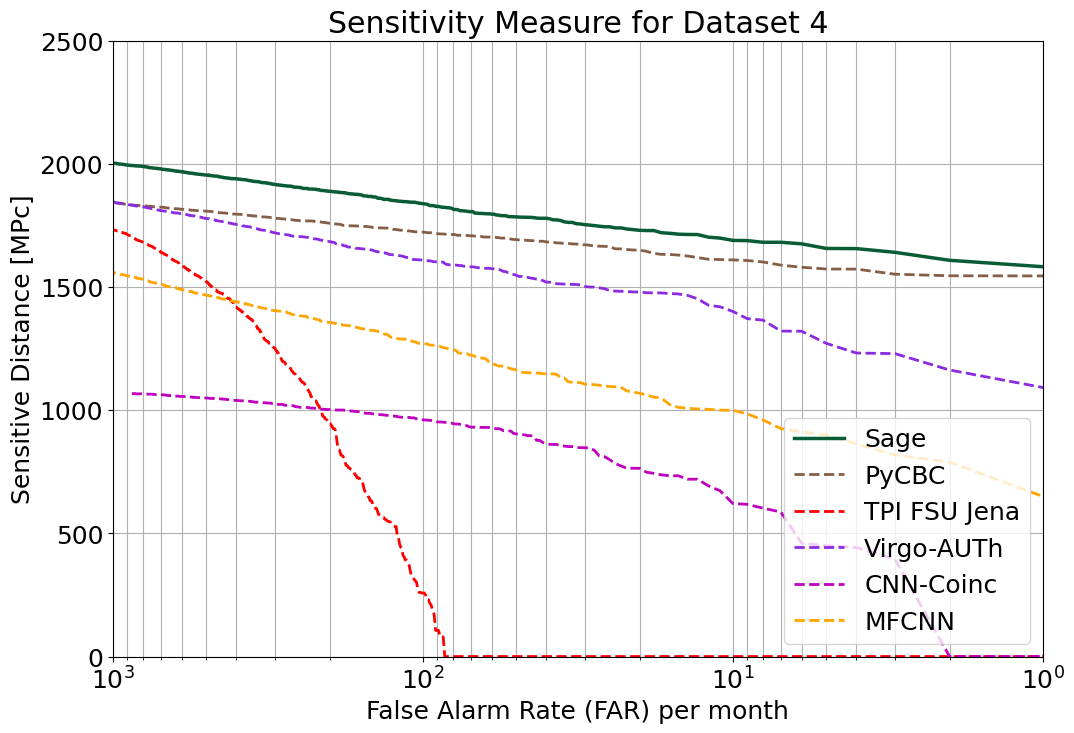

In [251]:
plt.figure(figsize=(12.0, 8.0))
plt.title('Sensitivity Measure for Dataset {}'.format(dataset))
plt.plot(far*(month/dur), sens, color=sage_green, linewidth=2.5, label='Sage')

with h5py.File('/home/nnarenraju/Research/ORChiD/results/PyCBC/ds{}/eval.hdf'.format(dataset)) as fp:
    sens_pycbc = np.array(fp['sensitive-distance'])
    far_pycbc = np.array(fp['far'])
plt.plot(far_pycbc*month, sens_pycbc, color=dark_brown, linewidth=2.0, linestyle='dashed', label='PyCBC')

with h5py.File('/home/nnarenraju/Research/ORChiD/results/TPI_FSU_Jena/ds{}/eval.hdf'.format(dataset)) as fp:
    sens_fsu = np.array(fp['sensitive-distance'])
    far_fsu = np.array(fp['far'])
plt.plot(far_fsu*month, sens_fsu, color='red', linewidth=2.0, linestyle='dashed', label='TPI FSU Jena')

with h5py.File('/home/nnarenraju/Research/ORChiD/results/Virgo-AUTh/ds{}/eval.hdf'.format(dataset)) as fp:
    sens_virgo = np.array(fp['sensitive-distance'])
    far_virgo = np.array(fp['far'])
plt.plot(far_virgo*month, sens_virgo, color='blueviolet', linewidth=2.0, linestyle='dashed', label='Virgo-AUTh')

with h5py.File('/home/nnarenraju/Research/ORChiD/results/CNN-Coinc/ds{}/eval.hdf'.format(dataset)) as fp:
    sens_cnn = np.array(fp['sensitive-distance'])
    far_cnn = np.array(fp['far'])
plt.plot(far_cnn*month, sens_cnn, color='m', linewidth=2.0, linestyle='dashed', label='CNN-Coinc')

with h5py.File('/home/nnarenraju/Research/ORChiD/results/MFCNN/ds{}/eval.hdf'.format(dataset)) as fp:
    sens_mfcnn = np.array(fp['sensitive-distance'])
    far_mfcnn = np.array(fp['far'])
plt.plot(far_mfcnn*month, sens_mfcnn, color='orange', linewidth=2.0, linestyle='dashed', label='MFCNN')

plt.grid(True, which='both')
plt.xlim(1000, 1)
plt.ylim(0, 2500)
plt.xscale('log')
plt.xlabel('False Alarm Rate (FAR) per month')
plt.ylabel('Sensitive Distance [MPc]')
plt.legend()
plt.savefig("./evaluation_plots/sensitive_distance_all_teams.png", bbox_inches='tight', dpi=300)

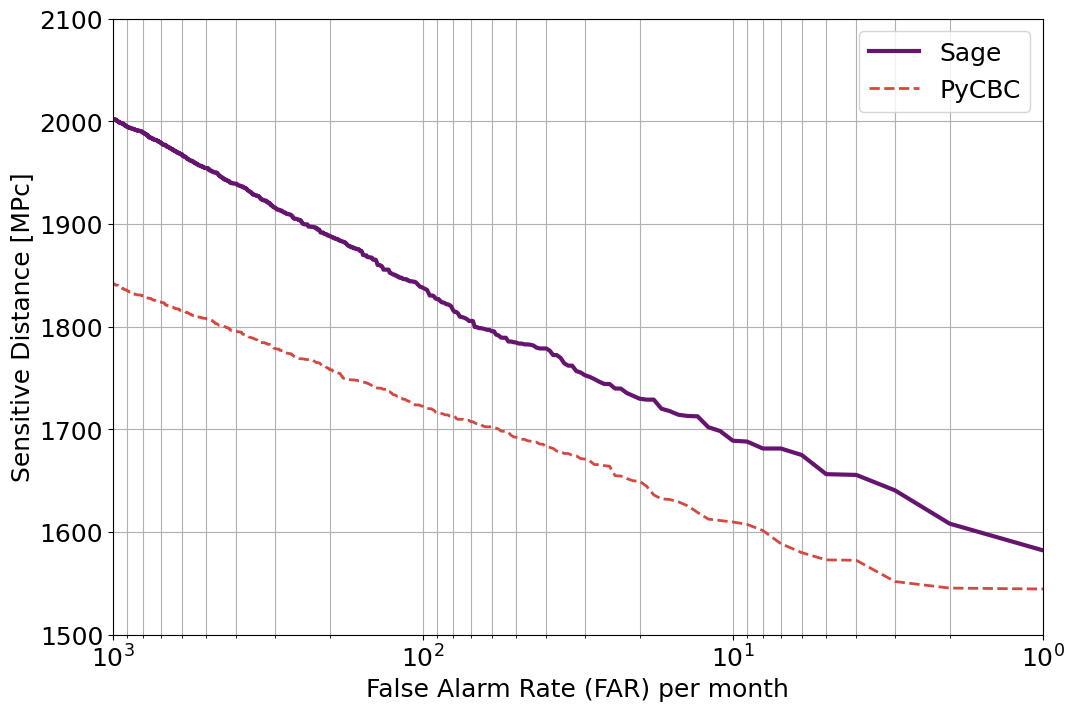

In [252]:
plt.figure(figsize=(12.0, 8.0))
# "#D44842", "#65156E"
plt.plot(far*(month/dur), sens, color="#65156E", linewidth=3.0, label='Sage')

with h5py.File('/home/nnarenraju/Research/ORChiD/results/{}/ds{}/eval.hdf'.format('PyCBC', dataset)) as fp:
    sens_team2 = np.array(fp['sensitive-distance'])
    far_team2 = np.array(fp['far'])
    plt.plot(far_team2*month, sens_team2, color="#D44842", linewidth=2.0, linestyle='dashed', label='{}'.format('PyCBC'))

plt.grid(True, which='both')
plt.xlim(1000, 1)
plt.ylim(1500, 2100)
plt.xscale('log')
plt.xlabel('False Alarm Rate (FAR) per month')
plt.ylabel('Sensitive Distance [MPc]')
plt.legend()
plt.savefig("./evaluation_plots/sensitive_distance_pycbc_sage.png", bbox_inches='tight', dpi=300)


### ROC Curve Comparison

In [112]:
def figure(title=""):
    # plt.rc('font', family='serif')
    plt.rc('xtick', labelsize='medium')
    plt.rc('ytick', labelsize='medium')
    fig, axs = plt.subplots(1, figsize=(16.0, 14.0))
    fig.suptitle(title, fontsize=18, y=0.92)
    return axs, fig


def _plot(ax, x=None, y=None, xlabel="x-axis", ylabel="y-axis", ls='solid', 
          label="NULL", c=None, yscale='linear', xscale='linear', histogram=False):
    
    # Plotting type
    if histogram:
        ax.hist(y, bins=100, label=label, alpha=0.8)
    else:
        ax.plot(x, y, ls=ls, c=c, linewidth=3.0, label=label)
    
    # Plotting params
    ax.set_xscale(xscale)
    ax.set_yscale(yscale)
    ax.grid(True, which='both')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend()

In [113]:
def read_network_output(fgpath, bgpath):
    with h5py.File(fgpath, 'r') as fp:
        fg_events = [np.vstack([fp['time'], fp['stat'], fp['var']])]
    fg_events = np.concatenate(fg_events, axis=-1)
    sidxs = fg_events[0].argsort()
    fg_events = fg_events.T[sidxs].T
    
    # Read background events
    with h5py.File(bgpath, 'r') as fp:
        bg_events = [np.vstack([fp['time'], fp['stat'], fp['var']])]
    bg_events = np.concatenate(bg_events, axis=-1)
    sidxs = bg_events[0].argsort()
    bg_events = bg_events.T[sidxs].T

    return fg_events, bg_events

In [114]:
## Foreground and background dataset outputs from pipeline
teams = {'PyCBC': {'fg_events': None, 'bg_events': None}, 
         'Sage': {'fg_events': None, 'bg_events': None}}

# Paths
# fgpath = ["/home/nnarenraju/Research/ORChiD/results/PyCBC/ds4/fg.hdf", foutput]
# bgpath = ["/home/nnarenraju/Research/ORChiD/results/PyCBC/ds4/bg.hdf", boutput]
fout = "/home/nnarenraju/Research/ORChiD/test_data_d4/testing_foutput_annealed_training.hdf"
bout = "/home/nnarenraju/Research/ORChiD/test_data_d4/testing_boutput_annealed_training.hdf"
fgpath = ["/home/nnarenraju/Research/ORChiD/results/PyCBC/ds4/fg.hdf", fout]
bgpath = ["/home/nnarenraju/Research/ORChiD/results/PyCBC/ds4/bg.hdf", bout]
# Get data from the outputs files
for fgp, bgp, tname in zip(fgpath, bgpath, teams.keys()):
    fg_events, bg_events = read_network_output(fgp, bgp)
    teams[tname]['bg_events'] = bg_events
    teams[tname]['fg_events'] = fg_events

## Injections file and foreground file data
injfile = injections
fgfile = foreground

In [25]:
# Find all valid injection times for the given testing dataset
duration, valid_idxs = find_injection_times([fgfile], injfile)
# Read the injections file and get the values of injection params
print("Reading the injections file for testing dataset")
assert all(team_1['tc'] == team_2['tc'])
tc = team_1['tc']

Reading the injections file for testing dataset


In [26]:
def find_nclosest_index(trigger_times, injection_times, frange=[-0.3, +0.3]):
    # Find nclosest triggers given an injection time
    if len(trigger_times) == 0:
        raise ValueError('Cannot find closest index for empty trigger times array.')
    
    # Sort array before proceeding
    array = trigger_times.copy()
    array.sort()
    
    # Find nclosest indices for the given value in array
    tidxs = [np.argwhere((array >= inj + frange[0]) & (array <= inj + frange[1])) for inj in tqdm(injection_times)]
    return tidxs

In [279]:
ax, _ = figure(title=None)

# Save ROC data
save = {}
save['Sage'] = {'fpr': None, 'tpr': None}
save['PyCBC'] = {'fpr': None, 'tpr': None}

for tname in teams.keys():
    print("\nComputing ROC Curve for {}".format(tname))
    fg_events = teams[tname]['fg_events']
    bg_events = teams[tname]['bg_events']

    ## Outputs and Labels for FG and BG
    outputs = []
    labels = []
    
    """ Foreground file analysis """
    print("\nAnalysing the foreground data")
    # Read the foreground output and get all the trigger times found
    fg_trigger_times = fg_events[0]
    fg_trigger_stats = fg_events[1]

    # Given all the valid injection times present in the injections file
    # get idx of all triggers that are within a bound of the given injection time
    print("Getting closest trigger indices for each valid injection time")
    fg_bound_triggers_idx = find_nclosest_index(trigger_times=fg_trigger_times, injection_times=injparams['tc'], frange=[-0.3, +0.3])
    
    print("Maximising over each set of triggers and obtaining the output and labels for ROC curve")
    ## Get outputs and labels to get ROC curve
    pbar = tqdm(fg_bound_triggers_idx)
    for btidx in pbar:
        pbar.set_description("Maximising FG triggers")
        if len(btidx) > 0:
            # Maximise on these triggers to get the event
            outputs.append(np.max(fg_trigger_stats[btidx]))
        else:
            # If there are no triggers given, then we assign 0.0 stat for event
            outputs.append(-np.inf)
        # Append labels as 1.0 since only GW events are looked at
        labels.append(1.0)
    
    """ Background file analysis """
    print("\nAnalysing the background data")
    # Read the foreground output and get all the trigger times found
    bg_trigger_times = bg_events[0]
    bg_trigger_stats = bg_events[1]
    
    # Given all the valid injection times present in the injections file
    # get idx of all triggers that are within a bound of the given injection time
    print("Getting closest trigger indices for each valid injection time")
    bg_bound_triggers_idx = find_nclosest_index(trigger_times=bg_trigger_times, injection_times=injparams['tc'], frange=[-0.3, +0.3])
    
    print("Maximising over each set of triggers and obtaining the output and labels for ROC curve")
    ## Get outputs and labels to get ROC curve
    pbar = tqdm(bg_bound_triggers_idx)
    for btidx in pbar:
        pbar.set_description("Maximising BG triggers")
        if len(btidx) > 0:
            # Maximise on these triggers to get the event
            outputs.append(np.max(bg_trigger_stats[btidx]))
        else:
            # If there are no triggers given, then we assign 0.0 stat for event
            outputs.append(-np.inf)
        # Append labels as 0.0 since only noise data is looked at
        labels.append(0.0)

    """ Calculating the ROC Curve """
    outputs = np.array(outputs)
    labels = np.array(labels)
    # Convert the outputs from raw outputs to prediction probabilites using sigmoid
    sigmoid = lambda x: 1./(1. + np.exp(-1*x))
    outputs = sigmoid(outputs)
    # Calculate the ROC curve
    fpr, tpr, threshold = metrics.roc_curve(labels, outputs)
    roc_auc = metrics.auc(fpr, tpr)

    # Log ROC Curve
    if tname == "PyCBC":
        colour = 'red'
    elif tname == "Sage":
        colour = "blue"

    # Save data
    save[tname]['fpr'] = fpr
    save[tname]['tpr'] = tpr
    _plot(ax, fpr, tpr, label="{}, AUC = {}".format(tname, np.around(roc_auc, 4)), c=colour, 
        ylabel="True Positive Rate", xlabel="False Positive Rate", 
        yscale='log', xscale='log')

# Other plotting stuff
_plot(ax, [0, 1], [0, 1], label="Random Classifier", c='k', 
    ylabel="True Positive Rate", xlabel="False Positive Rate", 
    ls="dashed", yscale='log', xscale='log')

save_path = "./evaluation_plots/roc_curve.png"
plt.savefig(save_path)
plt.close()


Computing ROC Curve for PyCBC

Analysing the foreground data
Getting closest trigger indices for each valid injection time


100%|██████████| 95719/95719 [00:08<00:00, 11149.18it/s]


Maximising over each set of triggers and obtaining the output and labels for ROC curve


Maximising FG triggers: 100%|██████████| 95719/95719 [00:57<00:00, 1673.24it/s]



Analysing the background data
Getting closest trigger indices for each valid injection time


100%|██████████| 95719/95719 [00:08<00:00, 11454.74it/s]


Maximising over each set of triggers and obtaining the output and labels for ROC curve


Maximising BG triggers: 100%|██████████| 95719/95719 [00:58<00:00, 1626.40it/s]



Computing ROC Curve for Sage

Analysing the foreground data
Getting closest trigger indices for each valid injection time


100%|██████████| 95719/95719 [03:02<00:00, 525.18it/s]


Maximising over each set of triggers and obtaining the output and labels for ROC curve


Maximising FG triggers: 100%|██████████| 95719/95719 [00:57<00:00, 1671.38it/s]



Analysing the background data
Getting closest trigger indices for each valid injection time


100%|██████████| 95719/95719 [02:52<00:00, 556.02it/s]


Maximising over each set of triggers and obtaining the output and labels for ROC curve


Maximising BG triggers: 100%|██████████| 95719/95719 [00:58<00:00, 1645.24it/s]


In [280]:
plt.rcParams.update({
    "font.size": 18
})

/tmp/ipykernel_1951857/346790160.py:9: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0.0, 1.0)
/tmp/ipykernel_1951857/346790160.py:10: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0.0, 1.0)


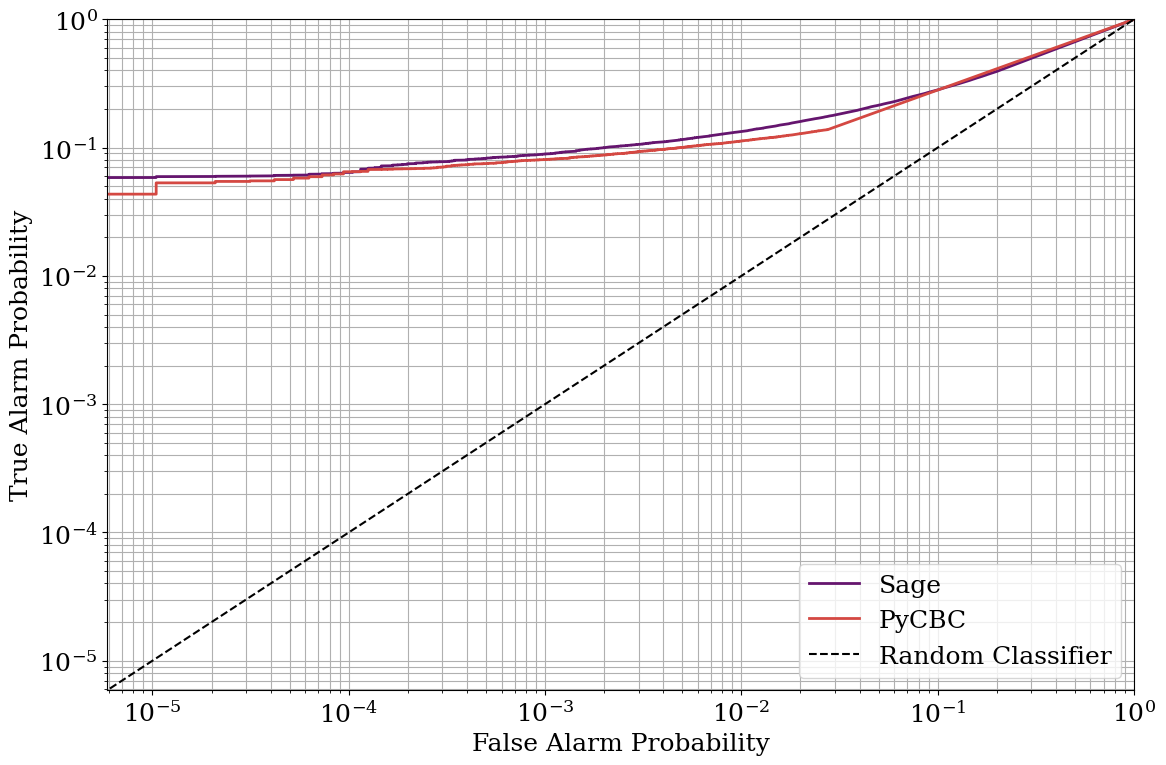

In [281]:
# Plotting
plt.figure(figsize=(12.0, 8.0))
# "#D44842", "#65156E"
plt.loglog(save['Sage']['fpr'], save['Sage']['tpr'], c="#65156E", label='Sage', linewidth=2.0)
plt.loglog(save['PyCBC']['fpr'], save['PyCBC']['tpr'], c="#D44842", label='PyCBC', linewidth=2.0)
plt.plot([0, 1], [0, 1], label='Random Classifier', c='k', linestyle='dashed')
plt.xlabel('False Alarm Probability')
plt.ylabel('True Alarm Probability')
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)
plt.grid(which='both')
plt.legend(loc='lower right')
save_path = "./evaluation_plots/roc_pycbc_sage.png"
plt.tight_layout()
plt.savefig(save_path, bbox_inches='tight', dpi=300)
plt.show()

### Glitch Rejection Capabilities

In [115]:
glitch_names = ['1400Ripples', '1080Lines', 'Air_Compressor', 'Blip', 'Chirp', 'Extremely_Loud', 'Helix',
                'Koi_Fish', 'Light_Modulation', 'Low_Frequency_Burst', 'Low_Frequency_Lines', 'No_Glitch', 
                'None_of_the_Above', 'Paired_Doves', 'Power_Line', 'Repeating_Blips', 'Scattered_Light', 
                'Scratchy', 'Tomte', 'Violin_Mode', 'Wandering_Line', 'Whistle']
map_to_idx = dict(zip(glitch_names, np.arange(len(glitch_names))))
map_to_names = dict(zip(np.arange(len(glitch_names)), glitch_names))

In [116]:
def get_glitch_data(detfile):
    # File containing glitch info H1 O3a
    filename = "/local/scratch/igr/nnarenraju/gwspy/{}.csv".format(detfile)
    gfile = pd.read_csv('{}'.format(filename))
    num_glitches_in_odet = len(gfile)
    print('H1 O3a contains {} glitches'.format(num_glitches_in_odet))
    glitch_probs = gfile.iloc[:, 15:37]
    glitch_types = []
    for i in range(num_glitches_in_odet):
        glitch_types.append(map_to_idx[glitch_probs.iloc[i].idxmax()])

    glitch_gps_times = np.array(gfile['event_time'])
    glitch_duration = np.array(gfile['duration'])
    glitch_snrs = np.array(gfile['snr'])
    return (glitch_gps_times, glitch_duration, glitch_snrs, glitch_types)

In [43]:
_, _, _, glitch_types = get_glitch_data('H1_O3a')

H1 O3a contains 80763 glitches


In [117]:
def glitches_in_testset(glitch_gps_times, glitch_duration, glitch_snrs, glitch_types):
    # We use the first 133 noise segments as testing noise
    # This contains start and end times
    noise_times = pd.read_csv('./tmp/segments.csv')[:133]
    # Check if a glitch reported in gravity spy is present within the start and end times of the noise segments
    num_present = 0
    glitch_gps_times_in_testset = []
    glitch_durations_in_testset = []
    glitch_snrs_in_testset = []
    glitch_types_in_testset = []
    for glitch_time, gdur, gsnr, gtype in tqdm(zip(glitch_gps_times, glitch_duration, glitch_snrs, glitch_types)):
        is_present = np.any((noise_times['start'] <= glitch_time) & (noise_times['end'] >= glitch_time))
        num_present += is_present
        if is_present:
            glitch_gps_times_in_testset.append(glitch_time)
            glitch_durations_in_testset.append(gdur)
            glitch_snrs_in_testset.append(gsnr)
            glitch_types_in_testset.append(gtype)
    print('There were {} glitches present in the testing data for H1 O3a'.format(num_present))
    return (glitch_gps_times_in_testset, glitch_durations_in_testset, glitch_snrs_in_testset, glitch_types_in_testset)

In [118]:
def find_nclosest_index_for_glitch(trigger_times, injection_times, glitch_duration):
    # Find nclosest triggers given an injection time
    if len(trigger_times) == 0:
        raise ValueError('Cannot find closest index for empty trigger times array.')
    
    # Sort array before proceeding
    array = trigger_times.copy()
    array.sort()
    
    # Find nclosest indices for the given value in array
    tidxs = []
    for inj, gdur in zip(injection_times, glitch_duration):
        tidxs.append(np.argwhere((array >= inj + (-1*gdur)) & (array <= inj + gdur)))
    return tidxs

In [119]:
# How close was the peak glitch time to a GW injection
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return abs(array[idx] - value)

In [120]:
def get_relevant_glitches(tname, glitch_gps_times_in_testset, glitch_duration, glitch_snrs_in_testset, glitch_types_in_testset):
    # Get the event time for glitches and get triggers around this GPS time
    # This procedure is similar to what we already have with the ROC curve code
    # Plot all network outputs without maximising against all noise triggers
    bg_events = teams[tname]['bg_events']

    """ Triggers around glitch time """
    # Read the background output and get all the trigger times found
    bg_trigger_times = bg_events[0]
    bg_trigger_stats = bg_events[1]

    # Given all the valid injection times present in the injections file
    # get idx of all triggers that are within a bound of the given injection time
    print("Getting closest trigger indices for each valid injection time")
    bg_bound_triggers_idx = find_nclosest_index_for_glitch(trigger_times=bg_trigger_times, injection_times=glitch_gps_times_in_testset, glitch_duration=glitch_duration)

    foo = team_1 if tname=='Sage' else team_2
    thresh_vals = dict(zip(['1-per-month', '1-per-week', '1-per-day', '100-per-month', '1000-per-month'], foo['far_thresholds']))
    print(thresh_vals)

    # Get glitch data
    glitch_stat_snr = []
    for btidx, gsnr, gtime, gtype in zip(bg_bound_triggers_idx, glitch_snrs_in_testset, glitch_gps_times_in_testset, glitch_types_in_testset):
        triggers = bg_trigger_stats[btidx]
        glitch_data = np.column_stack((triggers, np.full(len(triggers), gsnr), np.full(len(triggers), gtime), np.full(len(triggers), gtype)))
        glitch_stat_snr.append(glitch_data)

    # Combine all triggers
    glitch_stat_snr = np.row_stack((glitch_stat_snr))
    # Pick glitch stats that are above the FAR threshold for 1000/month
    # glitches_above_1000_per_month = glitch_stat_snr[glitch_stat_snr[:,0] > thresh_vals['1000-per-month']]
    glitches_above_1000_per_month = glitch_stat_snr
    print('Number of glitches above an FAR of 1000/month = {}'.format(glitches_above_1000_per_month.shape[0]))

    nearest_event_dt = []
    for gtime in glitches_above_1000_per_month[:,2]:
        nearest_event_dt.append(find_nearest(team_1['tc'], gtime))
    
    return (glitches_above_1000_per_month, thresh_vals, nearest_event_dt)


Current coord: H1_O3a, Sage
H1 O3a contains 80763 glitches


80763it [00:19, 4107.28it/s]


There were 16531 glitches present in the testing data for H1 O3a
Getting closest trigger indices for each valid injection time
{'1-per-month': 11.046875, '1-per-week': 10.5546875, '1-per-day': 9.53125, '100-per-month': 8.6953125, '1000-per-month': 6.796875}
Number of glitches above an FAR of 1000/month = 59748

Current coord: H1_O3a, PyCBC
H1 O3a contains 80763 glitches


80763it [00:13, 6024.65it/s]


There were 16531 glitches present in the testing data for H1 O3a
Getting closest trigger indices for each valid injection time
{'1-per-month': 4.4136152267456055, '1-per-week': 4.115692138671875, '1-per-day': 1.3865461349487305, '100-per-month': 0.0583043098449707, '1000-per-month': -2.999652862548828}
Number of glitches above an FAR of 1000/month = 3598

Current coord: L1_O3a, Sage
H1 O3a contains 127500 glitches


127500it [00:21, 5846.60it/s]


There were 28739 glitches present in the testing data for H1 O3a
Getting closest trigger indices for each valid injection time
{'1-per-month': 11.046875, '1-per-week': 10.5546875, '1-per-day': 9.53125, '100-per-month': 8.6953125, '1000-per-month': 6.796875}
Number of glitches above an FAR of 1000/month = 58297

Current coord: L1_O3a, PyCBC
H1 O3a contains 127500 glitches


127500it [00:21, 5964.88it/s]


There were 28739 glitches present in the testing data for H1 O3a
Getting closest trigger indices for each valid injection time
{'1-per-month': 4.4136152267456055, '1-per-week': 4.115692138671875, '1-per-day': 1.3865461349487305, '100-per-month': 0.0583043098449707, '1000-per-month': -2.999652862548828}
Number of glitches above an FAR of 1000/month = 3854


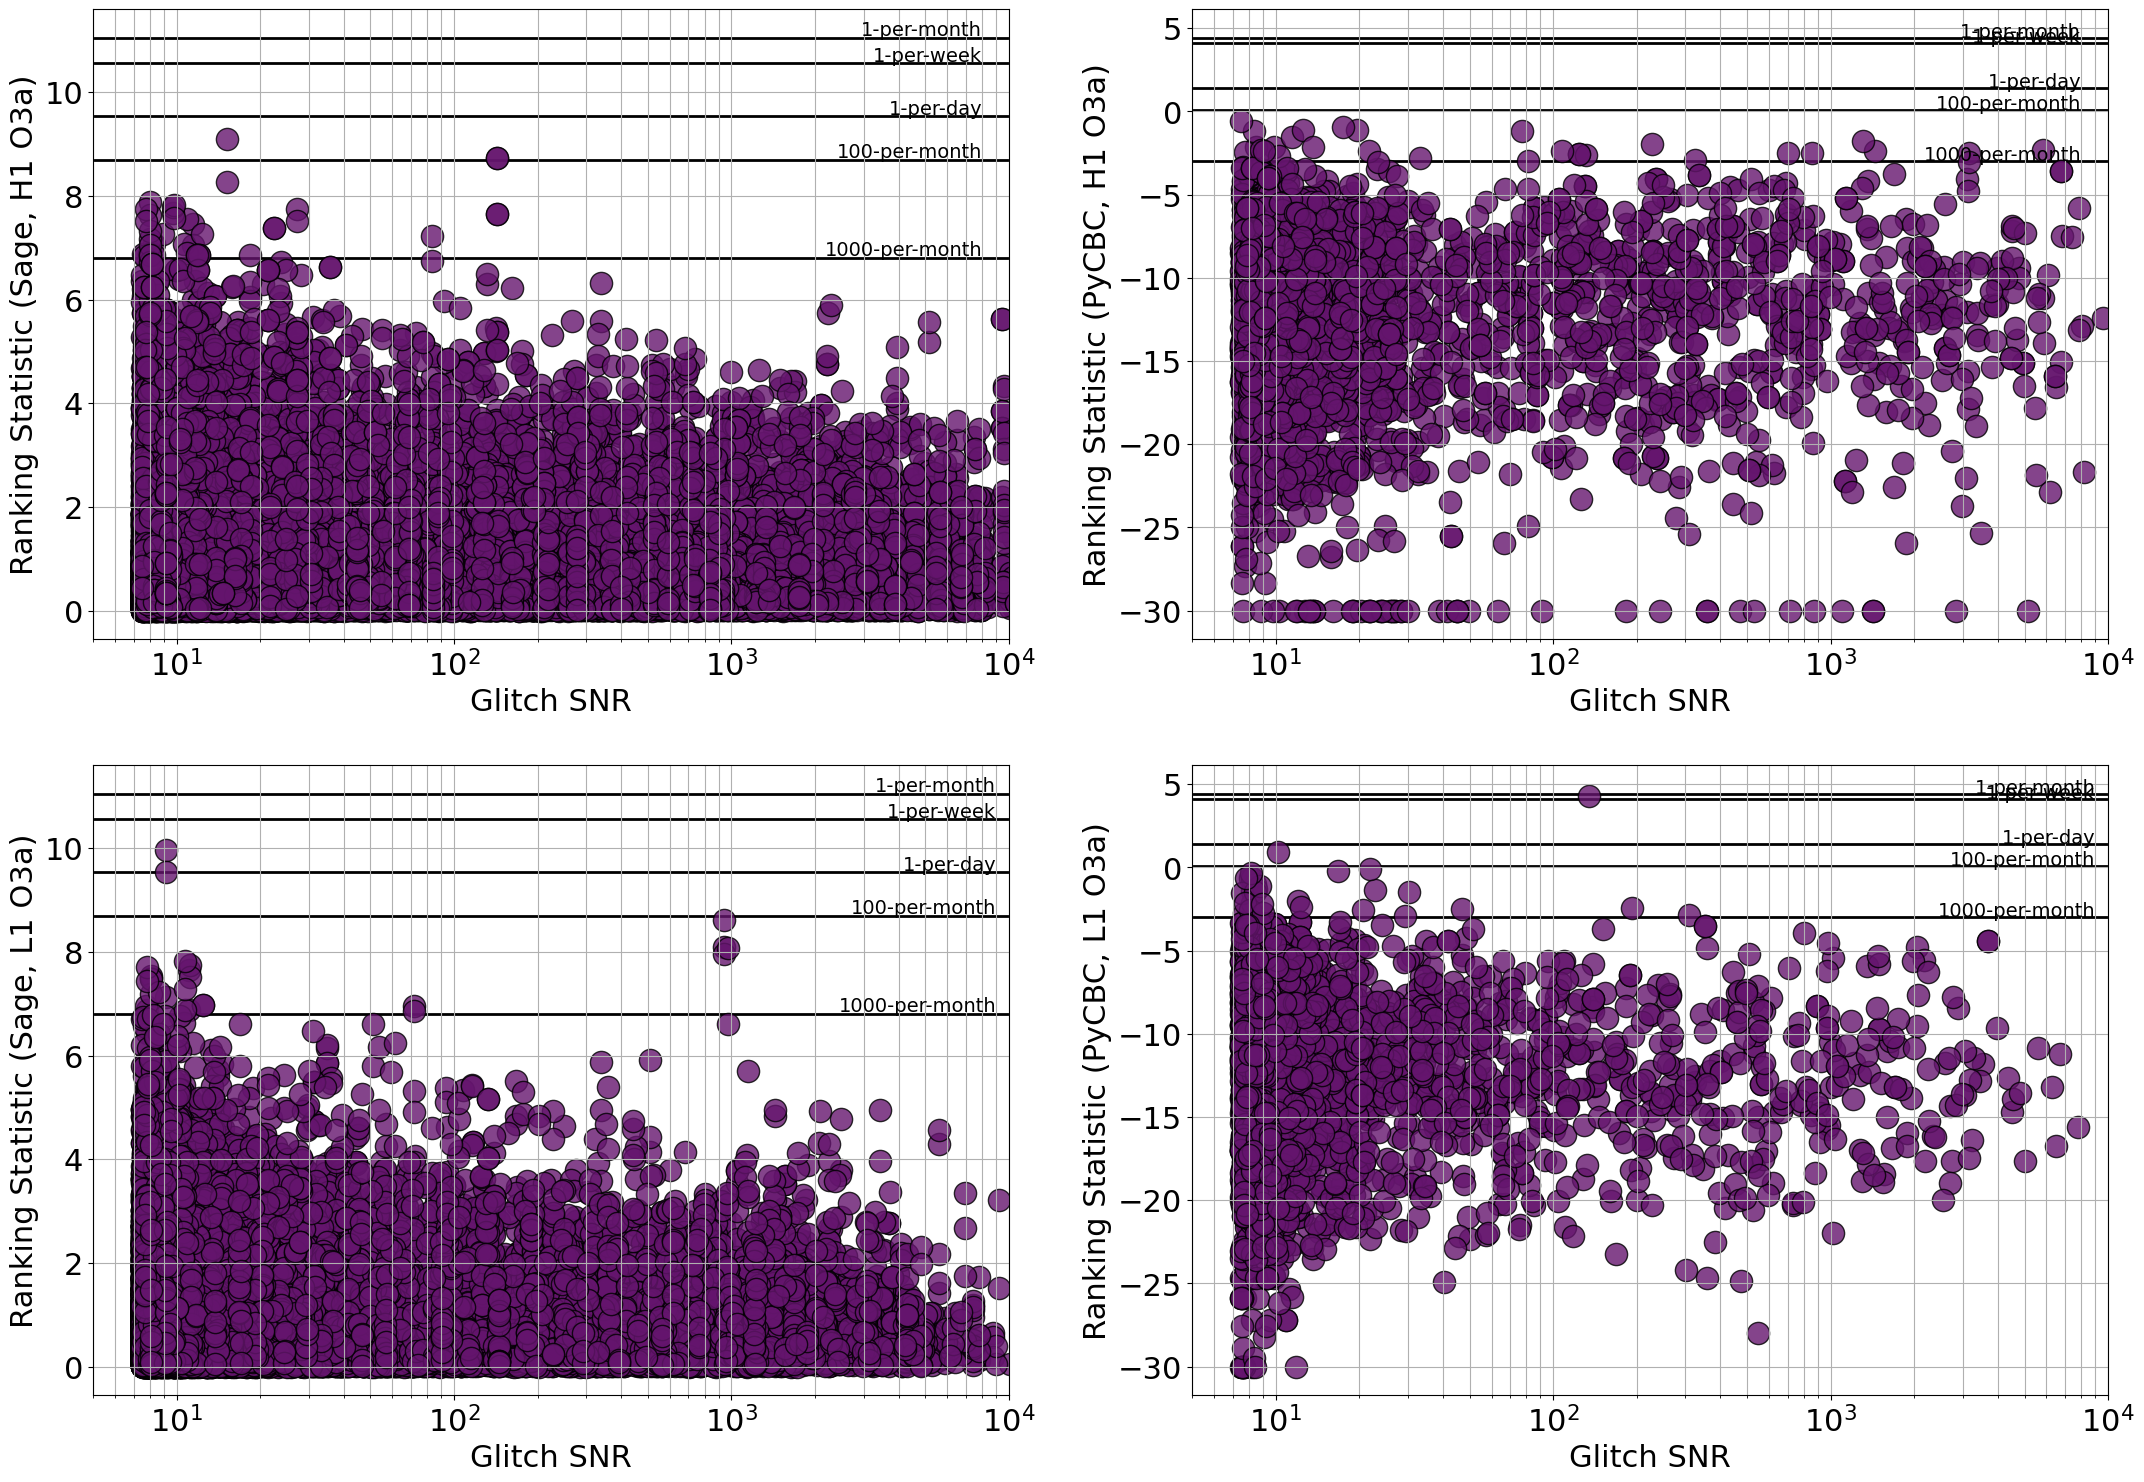

In [121]:
detfiles = ['H1_O3a', 'L1_O3a']
team_names = ['Sage', 'PyCBC']
coords = itertools.product(detfiles, team_names)

fig, axs = plt.subplots(2, 2, figsize=(13.0*2, 9.0*2))
axs = axs.flatten()

save_glitch_data = {'Sage':{'H1_O3a':None, 'L1_O3a':None}, 'PyCBC':{'H1_O3a':None, 'L1_O3a':None}}

for num, ((detfile, tname), ax) in enumerate(zip(coords, axs)):
    print('\nCurrent coord: {}, {}'.format(detfile, tname))
    if num == 0 or num == 2 or True:
        ax.set_ylabel('Ranking Statistic ({}, {})'.format(tname, detfile.replace('_', ' ')), fontsize=22)
    if num == 2 or num == 3 or True:
        ax.set_xlabel('Glitch SNR', fontsize=22)
    
    glitch_gps_times, glitch_duration, glitch_snrs, glitch_types = get_glitch_data(detfile)
    glitch_gps_times_in_testset, glitch_durations_in_testset, glitch_snrs_in_testset, glitch_types_in_testset = glitches_in_testset(glitch_gps_times, glitch_duration, glitch_snrs, glitch_types)
    glitches_above_1000_per_month, thresh_vals, nearest_event_dt = get_relevant_glitches(tname, glitch_gps_times_in_testset, glitch_duration, glitch_snrs_in_testset, glitch_types_in_testset)

    # Save glitch data
    save_glitch_data[tname][detfile] = glitches_above_1000_per_month

    # Plot all glitch triggers alongside the thresh vals
    xmin = min(glitches_above_1000_per_month[:,1]) - 0.1*min(glitches_above_1000_per_month[:,1])
    xmax = max(glitches_above_1000_per_month[:,1]) + 0.1*max(glitches_above_1000_per_month[:,1])
    xmin = 5.0
    xmax = 10_000
    n = len(thresh_vals.keys())

    # Threshold lines
    colors = np.array([raspberry, dark_red, dark_blue, dark_green, dark_purple])[::-1]
    for (thresh_name, thresh), c in zip(thresh_vals.items(), colors):
        ax.hlines(y=thresh, xmin=xmin, xmax=xmax, linewidth=2., label=thresh_name, colors='k', zorder=1)
    # Scatter plot of glitch triggers
    # foo = ax.scatter(glitches_above_1000_per_month[:,1], glitches_above_1000_per_month[:,0], s=256, alpha=0.8, c=nearest_event_dt, cmap='viridis_r', edgecolors='k')
    foo = ax.scatter(glitches_above_1000_per_month[:,1], glitches_above_1000_per_month[:,0], s=256, alpha=0.8, c="#65156E", edgecolors='k')

    # placing text instead of legend
    for thresh_name, tval in thresh_vals.items():
        factor = 0.9 if detfile == 'L1_O3a' else 0.8
        # ax.text(factor*max(glitches_above_1000_per_month[:,1]), tval+0.05, '{}'.format(thresh_name), horizontalalignment='right', fontsize=14)
        ax.text(factor*xmax, tval+0.05, '{}'.format(thresh_name), horizontalalignment='right', fontsize=14)

    """
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar = fig.colorbar(foo, cax=cax, orientation='vertical', alpha=1.0)
    if num == 1 or num == 3 or True:
        cbar.set_label(r'$\mathregular{min|T^{g} - T^{inj}_i|}$', rotation=90)
        cbar.set_alpha(1.0)
    """
    ax.grid(which='both')
    ax.set_xlim(xmin, xmax)
    ax.set_xscale('log')
    ax.tick_params(axis='both', which='major', labelsize=22)
    ax.tick_params(axis='both', which='minor', labelsize=22)

save_path = "./evaluation_plots/glitch_triggers.png"
# plt.tight_layout()
left  = 0.05    # the left side of the subplots of the figure
right = 0.1    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.1      # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.2   # the amount of height reserved for white space between subplots
plt.subplots_adjust(wspace=wspace)
plt.savefig(save_path, bbox_inches='tight', dpi=500)
plt.show()

In [50]:
# trigger, snr, gps_time, type
save_glitch_data['Sage']['H1_O3a']

array([[1.26464844e-01, 2.87920868e+02, 1.23840439e+09, 7.00000000e+00],
       [2.57031250e+00, 2.87920868e+02, 1.23840439e+09, 7.00000000e+00],
       [3.31054688e+00, 2.87920868e+02, 1.23840439e+09, 7.00000000e+00],
       ...,
       [6.65527344e-01, 2.76514923e+02, 1.24335201e+09, 7.00000000e+00],
       [3.46435547e-01, 1.47597103e+01, 1.24335175e+09, 3.00000000e+00],
       [3.47656250e-01, 1.47597103e+01, 1.24335175e+09, 3.00000000e+00]])

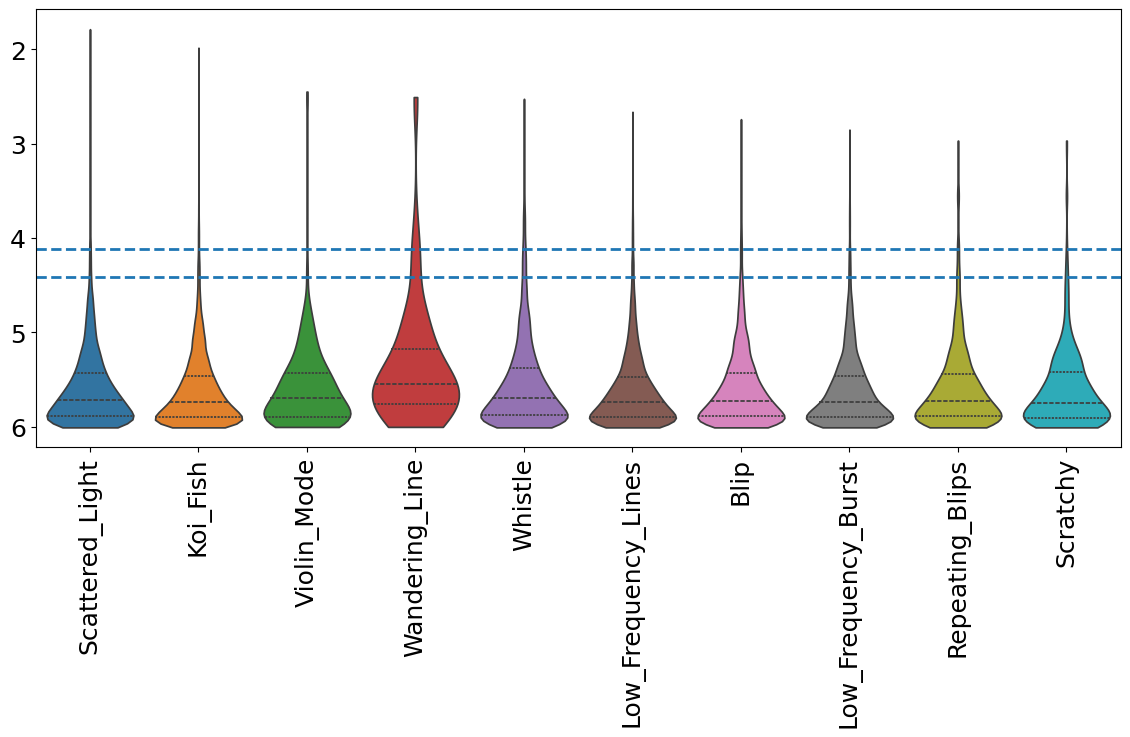

In [147]:
def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value


def set_axis_style(ax, labels):
    ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
    ax.set_xlim(0.25, len(labels) + 0.75)


# create test data
check = 'H1_O3a'
# Convert triggers to FAR/month
sage_stats_in_far = [np.log10(len(team_1['noise_stats'][team_1['noise_stats'] > foo])) for foo in save_glitch_data['Sage'][check][:,0]]
#pycbc_stats_in_far = [np.log10(len(team_2['noise_stats'][team_2['noise_stats'] > foo])) for foo in save_glitch_data['PyCBC'][check][:,0]]
#sage_stats_in_far = save_glitch_data['Sage'][check][:,0]
pycbc_stats_in_far = save_glitch_data['PyCBC'][check][:,0]
sage_triggers = np.column_stack((save_glitch_data['Sage'][check][:,3], sage_stats_in_far))
pycbc_triggers = np.column_stack((save_glitch_data['PyCBC'][check][:,3], pycbc_stats_in_far))

# Iterate through all glitch types
save_sage_triggers = {}
save_pycbc_triggers = {}
save_sage_triggers_nums = {}
save_pycbc_triggers_nums = {}
for i in range(22):
    # Get all triggers for a particular glitch type
    # Get triggers for Sage and PyCBC
    save_sage_triggers[i] = sage_triggers[:,1][sage_triggers[:,0] == i]
    save_pycbc_triggers[i] = pycbc_triggers[:,1][pycbc_triggers[:,0] == i]
    # glitch_type, trigger_value
    save_sage_triggers_nums[i] = np.min(sage_triggers[:,1][sage_triggers[:,0] == i])
    # save_pycbc_triggers_nums[i] = np.min(pycbc_triggers[:,1][pycbc_triggers[:,0] == i])

# Which triggers types have the highest trigger values
highest_sage_triggers = dict(sorted(save_sage_triggers_nums.items(), key=lambda item: item[1], reverse=False))
#highest_pycbc_triggers = dict(sorted(save_pycbc_triggers_nums.items(), key=lambda item: item[1], reverse=False))
top10_glitches_sage = list(highest_sage_triggers.keys())[:10] # top 10 glitch types triggered by sage
#top10_glitches_pycbc = list(highest_pycbc_triggers.keys())[:] # top 10 glitch types triggered by pycbc

data = [save_sage_triggers[i][save_sage_triggers[i] > -999] for i in top10_glitches_sage]
# data = [save_pycbc_triggers[i][save_pycbc_triggers[i] > -5] for i in top10_glitches_pycbc]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 6))
# Make violin plot using searborn
labels = [map_to_names[foo] for foo in top10_glitches_sage]
ax = sns.violinplot({key:val for key, val in zip(labels, data)}, cut=0, inner='quart')
# Setting tick labels
plt.setp(ax.get_xticklabels(), rotation=90, horizontalalignment='center')
ax.set_ylim(ax.get_ylim()[::-1])

# Thesholds in FAR
for thresh_name, thresh in thresh_vals.items():
    ax.axhline(thresh, ls='--', linewidth=2., label=thresh_name)

plt.subplots_adjust(bottom=0.15, wspace=0.05)
plt.show()

2.384185791015625e-07 11.046875


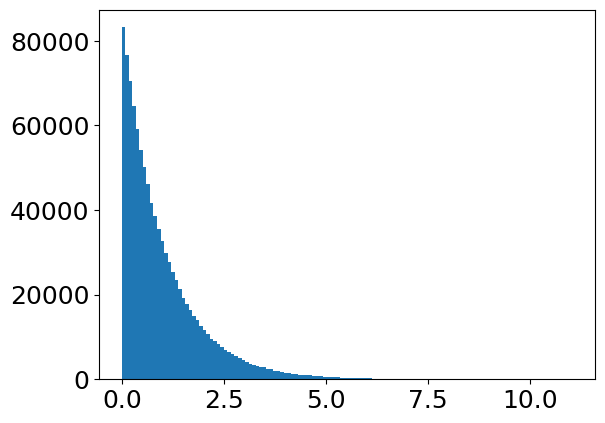

In [138]:
print(min(team_1['noise_stats']), max(team_1['noise_stats']))
plt.hist(team_1['noise_stats'], bins=128)
plt.show()

### Robustness to PSD realisations

In [ ]:
import pycbc
from pycbc import DYN_RANGE_FAC
from pycbc.filter import highpass as pycbc_highpass
from pycbc.psd import inverse_spectrum_truncation, welch, interpolate
from pycbc.types import TimeSeries, FrequencySeries
from pycbc.types import complex_same_precision_as

from noise_generator import NoiseGenerator
from make_signal import generate

In [ ]:
h1_psds_hdf="./tmp/psds_H1_latter51days_20s.hdf"
l1_psds_hdf="./tmp/psds_L1_latter51days_20s.hdf"

h1_psds = h5py.File(h1_psds_hdf, 'r')
shape_h1_psds = dict(h1_psds.attrs)['shape']
l1_psds = h5py.File(l1_psds_hdf, 'r')
shape_l1_psds = dict(h1_psds.attrs)['shape']

In [ ]:
fs = 2048. #Hz
sample_length_in_s = 20.0
noise_low_freq_cutoff = 15.0
signal_low_freq_cutoff = 20.0
trunc_method = 'hann'
whiten_padding = 5.0 # seconds

In [ ]:
def inv_spec_trunc(psd, max_filter_len):
    # Interpolate and smooth to the desired corruption length
    psd = inverse_spectrum_truncation(psd,
                                    max_filter_len=max_filter_len,
                                    low_frequency_cutoff=20.0,
                                    trunc_method='hann')
    return psd

In [ ]:
noise_generator = NoiseGenerator(delta_f=1./sample_length_in_s,
                                 sample_rate=2048.,
                                 low_frequency_cutoff=15.0)

In [ ]:
def psd_to_asd(psd, start_time, end_time,
               sample_rate=2048.,
               low_frequency_cutoff=15.0,
               filter_duration=128):
    
    psd = psd.copy()

    flen = int(sample_rate / psd.delta_f) // 2 + 1
    oldlen = len(psd)
    psd.resize(flen)

    # Want to avoid zeroes in PSD.
    max_val = psd.max()
    for i in range(len(psd)):
        if i >= (oldlen-1):
            psd.data[i] = psd[oldlen - 2]
        if psd[i] == 0:
            psd.data[i] = max_val

    fil_len = int(filter_duration * sample_rate)
    wn_dur = int(end_time - start_time) + 2 * filter_duration
    if psd.delta_f >= 1. / (2.*filter_duration):
        # If the PSD is short enough, this method is less memory intensive than
        # resizing and then calling inverse_spectrum_truncation
        psd = pycbc.psd.interpolate(psd, 1.0 / (2. * filter_duration))
        # inverse_spectrum_truncation truncates the inverted PSD. To truncate
        # the non-inverted PSD we give it the inverted PSD to truncate and then
        # invert the output.
        psd = 1. / pycbc.psd.inverse_spectrum_truncation(
                                1./psd,
                                fil_len,
                                low_frequency_cutoff=low_frequency_cutoff,
                                trunc_method='hann')
        psd = psd.astype(complex_same_precision_as(psd))
        # Zero-pad the time-domain PSD to desired length. Zeroes must be added
        # in the middle, so some rolling between a resize is used.
        psd = psd.to_timeseries()
        psd.roll(fil_len)
        psd.resize(int(wn_dur * sample_rate))
        psd.roll(-fil_len)
        # As time series is still mirrored the complex frequency components are
        # 0. But convert to real by using abs as in inverse_spectrum_truncate
        psd = psd.to_frequencyseries()

    kmin = int(low_frequency_cutoff / psd.delta_f)
    psd[:kmin].clear()
    asd = (psd.squared_norm())**0.25
    return asd

: 

In [ ]:
det = 'H1'

: 

In [ ]:
# Making a single signal to be placed in different PSD realisations
waveform_kwargs = {}
waveform_kwargs['delta_t'] = 1./2048.
waveform_kwargs['f_lower'] = 20.0 # Hz
waveform_kwargs['approximant'] = 'IMRPhenomXPHM'
waveform_kwargs['f_ref'] = 20.0 # Hz
waveform_kwargs['mass1'] = 20.0
waveform_kwargs['mass2'] = 10.0
waveform_kwargs['spin1z'] = 0.0
waveform_kwargs['spin2z'] = 0.0
waveform_kwargs['inclination'] = 0.0
waveform_kwargs['coa_phase'] = 2.45
waveform_kwargs['injection_time'] = 1244166018
waveform_kwargs['polarization'] = 2.34
waveform_kwargs['dec'] = 0.65
waveform_kwargs['ra'] = 4.67
waveform_kwargs['tc'] = 13.2
waveform_kwargs['distance'] = 3000.0 # Mpc

signal = generate(waveform_kwargs)
crop = int(whiten_padding/2.*2048.)
signal = signal[0][crop:-crop]

: 

In [ ]:
plt.plot(signal)

: 

In [ ]:
if det == 'H1':
    total_num = int(shape_h1_psds[0])
    det_psds = h1_psds['data']
elif det == 'L1':
    total_num = int(shape_l1_psds[0])
    det_psds = l1_psds['data']

for cidx in range(total_num):
    psd = det_psds[cidx]
    psd = FrequencySeries(psd, delta_f=1./sample_length_in_s)
    psd = interpolate(psd, 1./sample_length_in_s)
    max_filter_len = int(round(0.1 * fs))
    psd = inv_spec_trunc(psd, max_filter_len)
    asd = psd_to_asd(psd, 0.0, 20.0,
                    sample_rate=2048.,
                    low_frequency_cutoff=15.0,
                    filter_duration=20.0)
    # Create noise realisation with given PSD
    noise = noise_generator(2.5, 2.5+sample_length_in_s, seed=cidx, asd=asd)
    noise = noise.numpy()
    # Cropping
    crop = slice(int(whiten_padding/2.*fs), -int(whiten_padding/2.*fs))
    noise = noise[crop]
    # Create noisy signal sample
    noisy_signal = signal + noise
    plt.plot(noisy_signal)
    raise

: 